In [1]:
import itertools

import numpy as np
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier

# Task 1

Split the data

In [2]:
def splitdata_train_test(data, fraction_training):
    # Shuffle the data
    np.random.shuffle(data)
    
    # Split the data
    limit = int(len(data)*fraction_training)
    training = data[0:limit]
    testing = data[limit:]
    
    return training, testing


def main():
    data = np.load('data1/galaxy_catalogue.npy')

    # set the fraction of data which should be in the training set
    fraction_training = 0.7

    # split the data using your function
    training, testing = splitdata_train_test(data, fraction_training)

    # print the key values
    print('Number data galaxies:', len(data))
    print('Train fraction:', fraction_training)
    print('Number of galaxies in training set:', len(training))
    print('Number of galaxies in testing set:', len(testing))


main()

Number data galaxies: 780
Train fraction: 0.7
Number of galaxies in training set: 546
Number of galaxies in testing set: 234


# Task 2

Generate feature targets

In [3]:
def generate_features_targets(data):
    targets = data['class']

    features = np.empty(shape=(len(data), 13))
    features[:, 0] = data['u-g']
    features[:, 1] = data['g-r']
    features[:, 2] = data['r-i']
    features[:, 3] = data['i-z']
    features[:, 4] = data['ecc']
    features[:, 5] = data['m4_u']
    features[:, 6] = data['m4_g']
    features[:, 7] = data['m4_r']
    features[:, 8] = data['m4_i']
    features[:, 9] = data['m4_z']

    # concentration in u filter
    features[:, 10] = data['petroR50_u']/data['petroR90_u']
    # concentration in r filter
    features[:, 11] = data['petroR50_r']/data['petroR90_r']
    # concentration in z filter
    features[:, 12] = data['petroR50_z']/data['petroR90_z']

    return features, targets


def main():
  data = np.load('data1/galaxy_catalogue.npy')

  features, targets = generate_features_targets(data)

  # The shape of each array to check the arrays are the correct dimensions 
  print("Features shape:", features.shape)
  print("Targets shape:", targets.shape)


main()

Features shape: (780, 13)
Targets shape: (780,)


# Task 3

Train the decision tree classifier

In [4]:
def dtc_predict_actual(data):
    # split the data into training and testing sets using a training
    # fraction of 0.7
    training, testing = splitdata_train_test(data, 0.7)

    # generate the feature and targets for the training and test sets
    # i.e. train_features, train_targets, test_features, test_targets
    train_features, train_targets = generate_features_targets(training)
    test_features, test_targets = generate_features_targets(testing)

    # instantiate a decision tree classifier
    dtr = DecisionTreeClassifier()

    # train the classifier with the train_features and train_targets
    dtr.fit(train_features, train_targets)

    # get predictions for the test_features
    predictions = dtr.predict(test_features)

    # return the predictions and the test_targets
    return predictions, test_targets


def main():
    data = np.load('data1/galaxy_catalogue.npy')
    
    predicted_class, actual_class = dtc_predict_actual(data)

    # Print some of the initial results
    print("Some initial results...\n   predicted,  actual")
    for i in range(10):
        print("{}. {}, {}".format(i, predicted_class[i], actual_class[i]))


main()

Some initial results...
   predicted,  actual
0. spiral, spiral
1. spiral, spiral
2. spiral, merger
3. elliptical, elliptical
4. spiral, merger
5. elliptical, elliptical
6. spiral, spiral
7. merger, spiral
8. elliptical, elliptical
9. elliptical, merger


# Task 4

Our accuracy score: 0.7897435897435897
Confusion matrix, without normalization
[[232   3  25]
 [  5 200  55]
 [ 23  53 184]]


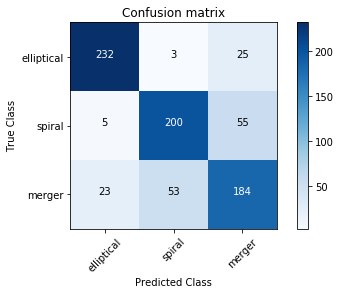

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')


def calculate_accuracy(predicted, actual):
    correct = sum(predicted == actual)
    return correct/(len(predicted))


def main():
    data = np.load('data1/galaxy_catalogue.npy')

    # split the data
    features, targets = generate_features_targets(data)

    # train the model to get predicted and actual classes
    dtc = DecisionTreeClassifier()
    predicted = cross_val_predict(dtc, features, targets, cv=10)

    # calculate the model score using your function
    model_score = calculate_accuracy(predicted, targets)
    print("Our accuracy score:", model_score)

    # calculate the models confusion matrix using sklearns confusion_matrix
    class_labels = list(set(targets))
    model_cm = confusion_matrix(y_true=targets, y_pred=predicted,
                                labels=class_labels)

    # Plot the confusion matrix using the provided functions.
    plt.figure()
    plot_confusion_matrix(model_cm, classes=class_labels, normalize=False)
    plt.show()


main()

# Task 5

Accuracy score: 0.8615384615384616
Confusion matrix, without normalization
[[245   1  14]
 [  3 218  39]
 [ 16  35 209]]


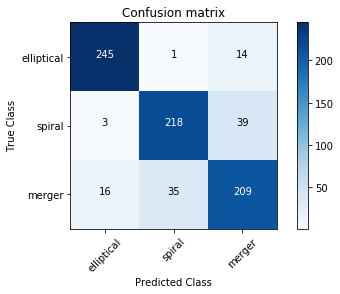

In [6]:
def rf_predict_actual(data, n_estimators):
    # generate the features and targets
    features, targets = generate_features_targets(data)

    # instantiate a random forest classifier using n estimators
    rfc = RandomForestClassifier(n_estimators=n_estimators)
  
    # get predictions using 10-fold cross validation with cross_val_predict
    predicted = cross_val_predict(rfc, features, targets, cv=10)

    # return the predictions and their actual classes
    return predicted, targets


def main():
    data = np.load('data1/galaxy_catalogue.npy')

    # get the predicted and actual classes
    number_estimators = 50              # Number of trees
    predicted, actual = rf_predict_actual(data, number_estimators)

    # calculate the model score using your function
    accuracy = calculate_accuracy(predicted, actual)
    print("Accuracy score:", accuracy)

    # calculate the models confusion matrix using sklearns confusion_matrix
    class_labels = list(set(actual))
    model_cm = confusion_matrix(y_true=actual, y_pred=predicted,
                                labels=class_labels)

    # plot the confusion matrix using the provided functions.
    plt.figure()
    plot_confusion_matrix(model_cm, classes=class_labels, normalize=False)
    plt.show()


main()